# Data exploration

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import re
import nltk
from collections import Counter
import os
from datetime import datetime
from tqdm import tqdm

nltk.download("stopwords")
stop_words = set(nltk.corpus.stopwords.words("english"))

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gregor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Sentiment140

In [4]:
df = pd.read_csv("../data/sentiment140/training.1600000.processed.noemoticon.csv", encoding='latin1', header=None)

# Manually add columns since they are not present in the original csv
df.columns = ["target", "ids", "date", "flag", "user", "text"]

df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
print(f"Number of rows: {len(df)}")

Number of rows: 1600000


In [6]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

### `target`

In [7]:
print(f"Unique target values: {df["target"].unique()}")

Unique target values: [0 4]


The target variable (sentiment) only has values 0 (negative) and 4 (positive), even though 2 (neutral) should be present according to the Kaggle page. We will work with this data, but will transform 4 to 1 in the preprocessing.

In [50]:
df["target"].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

### `ids`

In [8]:
print(f"Unique ids values: {df["ids"].nunique()}")
print(f"Ids range: [{df["ids"].min()}, {df["ids"].max()}]")

Unique ids values: 1598315
Ids range: [1467810369, 2329205794]


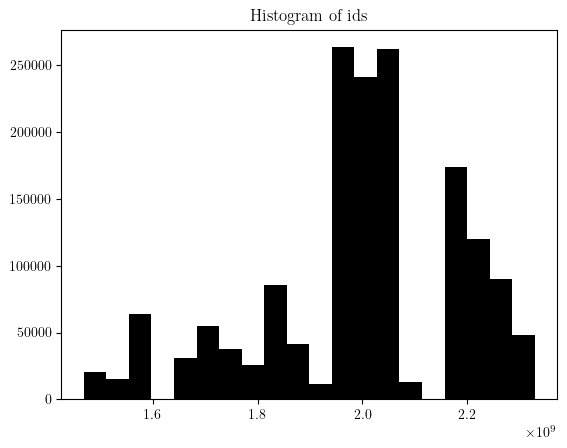

In [41]:
plt.hist(df["ids"], bins=20, color="black")
plt.title("Histogram of ids")
plt.show()

In [10]:
counts = df["ids"].value_counts()
non_unique = counts[counts != 1]
print(f"Number of non-unique ids: {len(non_unique)}")

Number of non-unique ids: 1685


We have multiple rows with duplicate ids.

In [11]:
example = df[df["ids"] == non_unique.index[0]]

print(example.iloc[0] == example.iloc[1])
print()
print(example.iloc[0]["text"])

target    False
ids        True
date       True
flag       True
user       True
text       True
dtype: bool

Had an injection today. Not fun  the rrst of the school day has been good. Tonight i am going dancing yey 


For this example, all values are the same except for the sentiment.

In [12]:
non_match_counts = {k: 0 for k in df.columns}
lens = []

for i in non_unique.index:
    examples = df[df["ids"] == non_unique.index[0]]
    
    lens.append(len(examples))

    for c in df.columns:
        if len(example[c].unique()) != 1:
            non_match_counts[c] += 1

print(f"Distribution of id duplicates: {np.unique(lens, return_counts=True)}")
print(f"Non-matchin columns counts: {non_match_counts}")

Distribution of id duplicates: (array([2]), array([1685]))
Non-matchin columns counts: {'target': 1685, 'ids': 0, 'date': 0, 'flag': 0, 'user': 0, 'text': 0}


We can see that for all duplicate ids appear at most twice and only the target differs. From this we can conclude that these examples have a neutral sentiment, which we will take into account in preprocessing.

### `date`

In [52]:
date_clean = df['date'].str.replace('PDT', '', regex=False).str.strip()
date_clean = pd.to_datetime(date_clean)

df["date"] = date_clean

date_clean.head()

0   2009-04-06 22:19:45
1   2009-04-06 22:19:49
2   2009-04-06 22:19:53
3   2009-04-06 22:19:57
4   2009-04-06 22:19:57
Name: date, dtype: datetime64[ns]

In [14]:
print(f"Minimum date: {date_clean.min()}")
print(f"Maximum date: {date_clean.max()}")

Minimum date: 2009-04-06 22:19:45
Maximum date: 2009-06-25 10:28:31


### `flag`

In [15]:
df["flag"].unique()

array(['NO_QUERY'], dtype=object)

Flag can be removed, since it is constant

### `user`

In [16]:
df["user"].value_counts()

user
lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
                  ... 
Laurendaly           1
laughingstars        1
jenniehager          1
fosking              1
ericDJ               1
Name: count, Length: 659775, dtype: int64

### `text`

In [18]:
def clean_tweet(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r"http\S+", "", text)

    # Remove mentions
    text = re.sub(r"@\w+", "", text)

    # Remove hashtags
    text = re.sub(r"#\w+", "", text)

    # Remove punctuation
    text = re.sub(r"[^\w\s]", "", text)

    # Remove numbers
    # text = re.sub(r"\d+", "", text) 

    # Remove extra whitespaces
    text = re.sub(r"\s+", " ", text).strip()

    return text

clean_text = df["text"].apply(clean_tweet)

In [34]:
# Join all tweets into a list of words
words = " ".join(clean_text).split()

# Remove stop words
words = [w for w in words if w not in stop_words]

word_count = Counter(words)

print("Most common words and their counts:")
for w, c in word_count.most_common(20):
    print(f"{w}\t{c}")

Most common words and their counts:
im	177518
good	89397
day	82918
get	81487
like	77749
go	72908
dont	66928
today	64609
going	64089
love	63453
work	62763
cant	62600
got	60754
time	56106
back	55979
lol	55183
u	52794
one	52191
know	51197
really	49550


In [46]:
negative_words = clean_text[df["target"] == 0]

# Join all tweets into a list of words
negative_words = " ".join(negative_words).split()

# Remove stop words
negative_words = [w for w in negative_words if w not in stop_words]

word_count = Counter(negative_words)

print("Most common words and their counts for negative sentiment:")
for w, c in word_count.most_common(20):
    print(f"{w}\t{c}")


Most common words and their counts for negative sentiment:
im	102643
get	45317
go	45125
dont	44916
work	44001
cant	43591
like	40640
day	38085
today	36196
going	33442
got	32983
back	32519
really	31221
miss	30502
want	29731
still	28761
good	28551
sad	27130
time	26768
one	26362


In [47]:
positive_words = clean_text[df["target"] == 4]

# Join all tweets into a list of words
positive_words = " ".join(positive_words).split()

# Remove stop words
positive_words = [w for w in positive_words if w not in stop_words]

word_count = Counter(positive_words)

print("Most common words and their counts for positive sentiment:")
for w, c in word_count.most_common(20):
    print(f"{w}\t{c}")


Most common words and their counts for positive sentiment:
im	74875
good	60846
love	46832
day	44833
like	37109
get	36170
thanks	33742
lol	33492
going	30647
u	30173
time	29338
today	28413
go	27783
got	27771
new	26637
one	25829
see	25463
know	25276
great	24883
well	24540


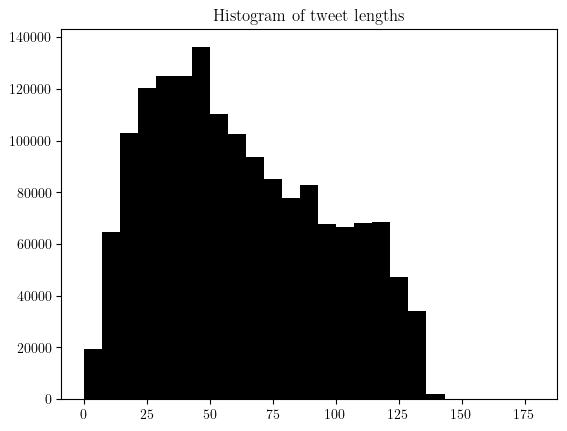

In [40]:
tweet_lens = clean_text.apply(len)

plt.hist(tweet_lens.to_numpy(), bins=25, color="black")
plt.title("Histogram of tweet lengths")
plt.show()

## Stock Market Dataset

In [102]:
path_etfs = "../data/stock_market_dataset/etfs"
path_stocks = "../data/stock_market_dataset/stocks"

dir_etfs = os.listdir(path_etfs)
dir_stocks = os.listdir(path_stocks)

min_date = datetime(2009, 4, 6)
max_date = datetime(2009, 6, 25)

etfs_list = []
stocks_list = []

for etf in tqdm(dir_etfs):
    df_etf = pd.read_csv(os.path.join(path_etfs, etf), parse_dates=["Date"])

    if pd.to_datetime(df_etf["Date"].max()) < min_date or pd.to_datetime(df_etf["Date"].min()) > max_date:
        continue

    df_etf = df_etf[(df_etf["Date"] >= min_date) & (df_etf["Date"] <= max_date)].copy()

    df_etf["Name"] = etf.split(".")[0]

    etfs_list.append(df_etf)

df_etfs = pd.concat(etfs_list, ignore_index=True)

for stock in tqdm(dir_stocks):
    df_stock = pd.read_csv(os.path.join(path_stocks, stock), parse_dates=["Date"])

    if pd.to_datetime(df_stock["Date"].max()) < min_date or pd.to_datetime(df_stock["Date"].min()) > max_date:
        continue

    df_stock = df_stock[(df_stock["Date"] >= min_date) & (df_stock["Date"] <= max_date)].copy()

    df_stock["Name"] = stock.split(".")[0]

    stocks_list.append(df_stock)

df_etfs = pd.concat(etfs_list, ignore_index=True)
df_stocks = pd.concat(stocks_list, ignore_index=True)

100%|██████████| 5884/5884 [01:16<00:00, 77.41it/s]


In [107]:
print(f"Number of ETFs: {len(df_etfs)}")
print(f"Number of stocks: {len(df_stocks)}")

Number of ETFs: 32604
Number of stocks: 189650


In [105]:
df_etfs.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2009-06-25,6142.399902,6161.600098,5856.00,5863.200195,5662.890625,800.0,SPXU
1,2009-04-06,12.290000,12.650000,12.08,12.640000,10.992745,132500.0,PPA
2,2009-04-07,12.480000,12.560000,12.24,12.300000,10.697052,49200.0,PPA
3,2009-04-08,12.330000,12.360000,12.20,12.300000,10.697052,31000.0,PPA
4,2009-04-09,12.590000,12.830000,12.58,12.780000,11.114499,33100.0,PPA


In [104]:
df_stocks.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2009-04-06,22.950001,23.400000,22.700001,23.150000,23.150000,4200.0,ANTE
1,2009-04-07,23.000000,23.000000,22.350000,22.549999,22.549999,4300.0,ANTE
2,2009-04-08,21.850000,22.850000,21.850000,22.799999,22.799999,9700.0,ANTE
3,2009-04-09,23.049999,25.000000,23.049999,24.750000,24.750000,13100.0,ANTE
4,2009-04-13,24.450001,26.950001,23.400000,26.850000,26.850000,13600.0,ANTE


In [108]:
df_stocks.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,189650,1.896480e+05,1.896480e+05,1.896480e+05,1.896480e+05,1.896480e+05,1.896480e+05
mean,2009-05-16 07:18:34.984445184,1.433003e+06,1.506806e+06,1.342961e+06,1.414303e+06,1.414299e+06,2.105223e+06
min,2009-04-06 00:00:00,2.000000e-04,2.000000e-04,2.000000e-04,2.000000e-04,-3.008796e-01,0.000000e+00
25%,2009-04-27 00:00:00,6.010000e+00,6.200000e+00,5.860000e+00,6.030000e+00,4.255662e+00,1.310000e+04
50%,2009-05-15 00:00:00,1.205000e+01,1.230000e+01,1.183000e+01,1.207000e+01,8.760249e+00,1.341000e+05
75%,2009-06-05 00:00:00,2.264000e+01,2.315375e+01,2.215000e+01,2.268000e+01,1.794000e+01,8.748250e+05
max,2009-06-25 00:00:00,8.946000e+09,9.777601e+09,7.686000e+09,8.870400e+09,8.870400e+09,1.626529e+09
std,NaN,8.610079e+07,9.101021e+07,7.971986e+07,8.464463e+07,8.464463e+07,1.660310e+07


In [109]:
df_etfs.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,32604,32604.000000,32604.000000,32604.000000,32604.000000,32604.000000,3.260400e+04
mean,2009-05-16 10:11:34.295178240,237.273473,244.949060,226.825533,234.539965,224.219033,4.142993e+06
min,2009-04-06 00:00:00,0.073000,0.073000,0.072000,0.072000,0.138265,0.000000e+00
25%,2009-04-27 00:00:00,16.950001,17.112500,16.760000,16.940001,13.741512,1.260000e+04
50%,2009-05-15 00:00:00,29.658333,30.059999,29.250000,29.700001,22.827331,6.881850e+04
75%,2009-06-05 00:00:00,46.570000,47.020000,45.939999,46.549999,37.680633,4.086000e+05
max,2009-06-25 00:00:00,70920.000000,75040.000000,68000.000000,72200.000000,70954.718750,7.152996e+08
std,NaN,2093.782457,2177.601820,1960.349547,2050.428464,2011.761584,2.565044e+07


In [123]:
df_etfs = df_etfs[df_etfs.groupby("Name")["Name"].transform("count") >= 10]
df_stocks = df_stocks[df_stocks.groupby("Name")["Name"].transform("count") >= 10]